In [2]:
import pandas as pd

import os

# Limit threads globally (optional but useful)
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["OPENBLAS_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["VECLIB_MAXIMUM_THREADS"] = "2"
os.environ["NUMEXPR_NUM_THREADS"] = "2"



import pandas as pd

# Load and combine datasets (as before)
datasets = {
    'benign': pd.read_csv('C:/Users/nazih/Downloads/cic_iot/labeled_dataset_benign.csv'),
    'dns': pd.read_csv('C:/Users/nazih/Downloads/cic_iot/labeled_dataset_DNS_spoofing.csv'),
    'mitm': pd.read_csv('C:/Users/nazih/Downloads/cic_iot/labeled_dataset_MITM_ArpSpoofing.csv')
}
combined_df = pd.concat([datasets['benign'], datasets['dns'], datasets['mitm']], ignore_index=True)
combined_df = combined_df.drop('dst_mac', axis=1)

print(combined_df.shape)

C:\Users\nazih\AppData\Local\Temp\ipykernel_2292\4110929105.py:19: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  'dns': pd.read_csv('C:/Users/nazih/Downloads/cic_iot/labeled_dataset_DNS_spoofing.csv'),
C:\Users\nazih\AppData\Local\Temp\ipykernel_2292\4110929105.py:20: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  'mitm': pd.read_csv('C:/Users/nazih/Downloads/cic_iot/labeled_dataset_MITM_ArpSpoofing.csv')


(883525, 135)


In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# --- Helper: Check if a value is a MAC address ---
def is_hex_mac(mac):
    if pd.isna(mac) or mac == 'unknown':
        return False
    pattern = r'^([0-9A-Fa-f]{2}[:-]){5}([0-9A-Fa-f]{2})$'
    return bool(re.match(pattern, str(mac)))

# --- Step 1: Filter + Clean ---
# Remove rows where src_mac is a real MAC address
combined_df = combined_df[~combined_df['src_mac'].apply(is_hex_mac)]

# Drop duplicates
print(f"Number of duplicate rows: {combined_df.duplicated().sum()}")
combined_df = combined_df.drop_duplicates()
print(f"New shape after removing duplicates: {combined_df.shape}")

# Identify categorical columns
categorical_cols = [col for col in combined_df.columns if combined_df[col].nunique() < 10 or combined_df[col].dtype == 'object']
print(f"Categorical features: {categorical_cols}")

# Convert all categorical columns to string and fill missing with 'unknown'
for col in categorical_cols:
    combined_df[col] = combined_df[col].astype(str).fillna('unknown')

# Fill missing numerical values with median
numerical_cols = combined_df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    combined_df[col] = combined_df[col].fillna(combined_df[col].median())

# --- Step 2: Split target labels and features ---
X = combined_df.drop(['Label', 'src_mac'], axis=1, errors='ignore')
y_attack = combined_df['Label']
y_device = combined_df['src_mac']

# Encode device labels
le_device = LabelEncoder()
y_device_encoded = le_device.fit_transform(y_device)

# --- Step 3: Normalize and Apply PCA ---
# Keep only numeric columns
X_numeric = X.select_dtypes(include=['number'])

# Normalize features using StandardScaler (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_scaled)

# Store column names for reduced PCA components
pca_feature_names = [f'PC{i+1}' for i in range(X_reduced.shape[1])]

# Convert to DataFrame for ease of use
X_reduced_df = pd.DataFrame(X_reduced, columns=pca_feature_names, index=X.index)

print(f"\n✅ Number of PCA features: {X_reduced.shape[1]}")
print(f"✅ Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

# --- Step 4: Trace which original features contribute most to each PC ---
original_features = X_numeric.columns
pca_components = pd.DataFrame(pca.components_, columns=original_features, index=pca_feature_names)

# Show top contributing features for each PCA component
print("\n🔍 Top contributing features per PCA component:")
for pc in pca_components.index:
    top_features = pca_components.loc[pc].abs().sort_values(ascending=False).head(5)
    print(f"{pc}: {', '.join(top_features.index)}")

# --- Step 5: Train/Test Split ---
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_reduced_df, y_attack, test_size=0.2, random_state=42, stratify=y_attack
)

X_train_device, X_test_device, y_train_device, y_test_device = train_test_split(
    X_reduced_df, y_device_encoded, test_size=0.2, random_state=42, stratify=y_device_encoded
)


Number of duplicate rows: 0
New shape after removing duplicates: (432555, 135)
Categorical features: ['src_mac', 'src_ip', 'dst_ip', 'port_class_dst', 'l4_tcp', 'l4_udp', 'ttl', 'handshake_version', 'handshake_ciphersuites', 'tls_server', 'http_request_method', 'http_host', 'http_response_code', 'user_agent', 'dns_server', 'dns_query_type', 'dns_len_ans', 'device_mac', 'eth_src_oui', 'eth_dst_oui', 'highest_layer', 'http_uri', 'http_content_len', 'http_content_type', 'icmp_type', 'icmp_checksum_status', 'icmp_data_size', 'Label']

✅ Number of PCA features: 23
✅ Total variance explained: 0.9527

🔍 Top contributing features per PCA component:
PC1: channel_10_mean, channel_30_mean, channel_60_mean, stream_30_mean, stream_60_mean
PC2: src_ip_5_mean, src_ip_mac_5_mean, src_ip_10_mean, src_ip_mac_10_mean, src_ip_1_mean
PC3: stream_jitter_30_mean, stream_jitter_60_mean, stream_jitter_10_mean, stream_jitter_5_mean, stream_jitter_5_sum
PC4: sum_p, average_p, med_p, q1, q1_e
PC5: jitter, stream_

In [8]:
# Add these imports alongside your other initial imports
from imblearn.over_sampling import ADASYN
from collections import Counter # Useful for seeing the class distribution before/after

# --------------------------------------------------------------------------
# --- NEW Step 6: Apply ADASYN to Training Data for Device Identification ---
# --------------------------------------------------------------------------
print("\n--- Applying ADASYN Resampling (for Device ID Model) ---")

# 1. Show original class distribution
print(f"Original Training Distribution (Device ID): {Counter(y_train_device)}")

# 2. Initialize and Apply ADASYN
# n_jobs=-1 uses all available processors for faster resampling
adasyn = ADASYN(random_state=42) 

# 3. Resample the training data
X_train_device_adasyn, y_train_device_adasyn = adasyn.fit_resample(
    X_train_device, y_train_device
)

X_train_attack_adasyn, y_train_attack_adasyn = adasyn.fit_resample(
    X_train_attack, y_train_attack
)

# 4. Show new class distribution and shape
print(f"ADASYN Resampled Training Distribution (Device ID): {Counter(y_train_device_adasyn)}")
print(f"New training data shape: {X_train_device_adasyn.shape}")





--- Applying ADASYN Resampling (for Device ID Model) ---
Original Training Distribution (Device ID): Counter({np.int64(6): 129453, np.int64(4): 22086, np.int64(3): 20242, np.int64(5): 13126, np.int64(34): 12527, np.int64(22): 10682, np.int64(50): 8814, np.int64(9): 8590, np.int64(42): 7711, np.int64(8): 7402, np.int64(51): 7062, np.int64(2): 6023, np.int64(37): 5769, np.int64(28): 5662, np.int64(35): 5189, np.int64(56): 5158, np.int64(1): 3923, np.int64(26): 3711, np.int64(39): 3395, np.int64(11): 2997, np.int64(14): 2724, np.int64(18): 2572, np.int64(20): 2570, np.int64(23): 2566, np.int64(21): 2566, np.int64(24): 2563, np.int64(30): 2562, np.int64(17): 2558, np.int64(19): 2514, np.int64(27): 2088, np.int64(0): 2011, np.int64(36): 1978, np.int64(32): 1850, np.int64(10): 1816, np.int64(54): 1743, np.int64(55): 1737, np.int64(45): 1737, np.int64(47): 1699, np.int64(46): 1675, np.int64(12): 1618, np.int64(43): 1503, np.int64(16): 1446, np.int64(31): 1369, np.int64(44): 1323, np.int64(52

In [9]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [ ]:
# Train attack detection model
rf_model_attack = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=2, class_weight='balanced')
rf_model_attack.fit(X_train_attack_adasyn, y_train_attack_adasyn)

# Train device identification model
rf_model_device = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=2, class_weight='balanced')
rf_model_device.fit(X_train_device_adasyn, y_train_device_adasyn)

In [11]:
# Evaluate Random Forest for attack detection
rf_y_pred_attack = rf_model_attack.predict(X_test_attack)
print("Random Forest - Attack Detection Performance:")
print(f"Accuracy: {accuracy_score(y_test_attack, rf_y_pred_attack):.2f}")
print(classification_report(y_test_attack, rf_y_pred_attack))


# Evaluate Random Forest for device identification
rf_y_pred_device = rf_model_device.predict(X_test_device)
print("\nRandom Forest - Device Identification Performance:")
print(f"Accuracy: {accuracy_score(y_test_device, rf_y_pred_device):.2f}")
print(classification_report(y_test_device, rf_y_pred_device, target_names=le_device.classes_))



Random Forest - Attack Detection Performance:
Accuracy: 0.99
                  precision    recall  f1-score   support

   BenignTraffic       0.99      0.99      0.99     26147
    DNS_Spoofing       0.99      0.99      0.99     28606
MITM-ArpSpoofing       1.00      0.99      0.99     31758

        accuracy                           0.99     86511
       macro avg       0.99      0.99      0.99     86511
    weighted avg       0.99      0.99      0.99     86511


Random Forest - Device Identification Performance:
Accuracy: 0.93
                                            precision    recall  f1-score   support

                       AMCREST WiFi Camera       0.81      0.87      0.84       503
                     AeoTec Smart Home Hub       0.83      0.90      0.86       981
                         Amazon Echo Dot 1       0.92      0.88      0.90      1505
                         Amazon Echo Dot 2       0.97      0.98      0.98      5061
                          Amazon Echo Show

Random Forest - Attack Detection Performance:
Accuracy: 0.99
                  precision    recall  f1-score   support

   BenignTraffic       0.99      0.99      0.99     26147
    DNS_Spoofing       0.99      0.99      0.99     28606
MITM-ArpSpoofing       1.00      0.99      0.99     31758

        accuracy                           0.99     86511
       macro avg       0.99      0.99      0.99     86511
    weighted avg       0.99      0.99      0.99     86511


Random Forest - Device Identification Performance:
Accuracy: 0.93
                                            precision    recall  f1-score   support

                       AMCREST WiFi Camera       0.81      0.87      0.84       503
                     AeoTec Smart Home Hub       0.83      0.90      0.86       981
                         Amazon Echo Dot 1       0.92      0.88      0.90      1505
                         Amazon Echo Dot 2       0.97      0.98      0.98      5061
                          Amazon Echo Show

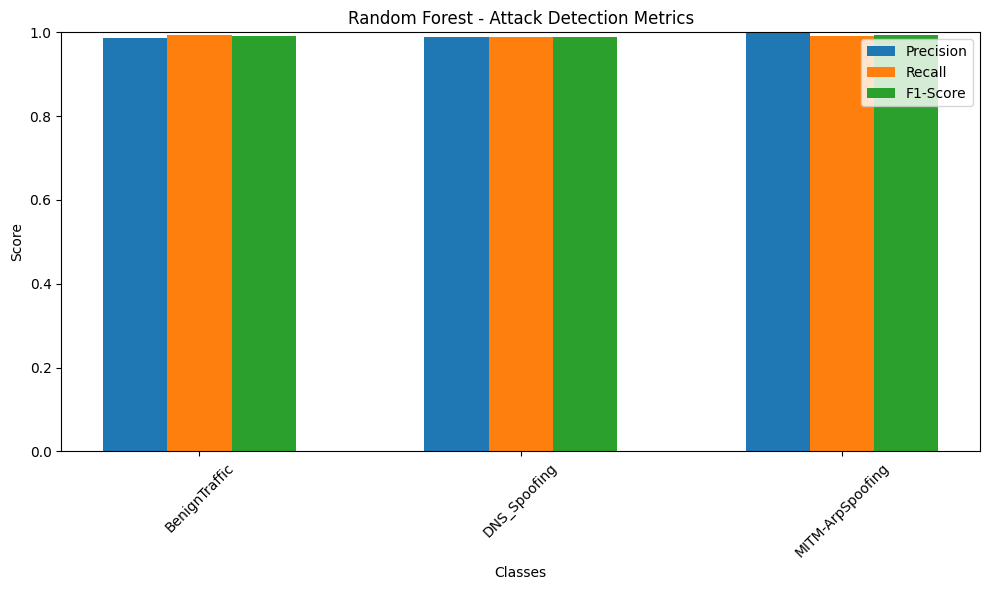

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# -------------------------------
# Attack detection evaluation
# -------------------------------
rf_y_pred_attack = rf_model_attack.predict(X_test_attack)
print("Random Forest - Attack Detection Performance:")
print(f"Accuracy: {accuracy_score(y_test_attack, rf_y_pred_attack):.2f}")
report_attack = classification_report(y_test_attack, rf_y_pred_attack, output_dict=True)
print(classification_report(y_test_attack, rf_y_pred_attack))

# -------------------------------
# Device identification evaluation
# -------------------------------
rf_y_pred_device = rf_model_device.predict(X_test_device)
print("\nRandom Forest - Device Identification Performance:")
print(f"Accuracy: {accuracy_score(y_test_device, rf_y_pred_device):.2f}")
report_device = classification_report(y_test_device, rf_y_pred_device, output_dict=True)
print(classification_report(y_test_device, rf_y_pred_device, target_names=le_device.classes_))

# -------------------------------
# Plotting Attack Detection Metrics
# -------------------------------
classes_attack = list(report_attack.keys())[:-3]  # exclude 'accuracy', 'macro avg', 'weighted avg'
precision_attack = [report_attack[cls]['precision'] for cls in classes_attack]
recall_attack = [report_attack[cls]['recall'] for cls in classes_attack]
f1_attack = [report_attack[cls]['f1-score'] for cls in classes_attack]

x = np.arange(len(classes_attack))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width, precision_attack, width, label='Precision')
ax.bar(x, recall_attack, width, label='Recall')
ax.bar(x + width, f1_attack, width, label='F1-Score')

ax.set_xlabel('Classes')
ax.set_ylabel('Score')
ax.set_title('Random Forest - Attack Detection Metrics')
ax.set_xticks(x)
ax.set_xticklabels(classes_attack, rotation=45)
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()




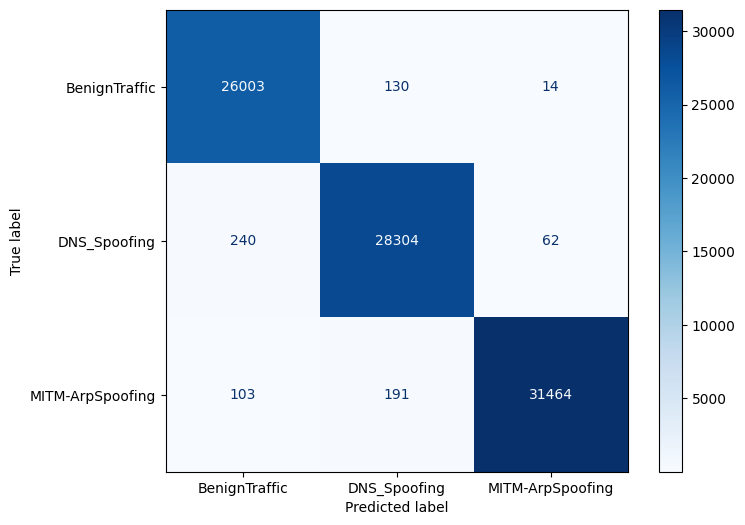

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# -------------------------------
# Confusion Matrix for Attack Detection
# -------------------------------
cm_attack = confusion_matrix(y_test_attack, rf_y_pred_attack)
disp_attack = ConfusionMatrixDisplay(confusion_matrix=cm_attack, display_labels=classes_attack)

fig, ax = plt.subplots(figsize=(8, 6))
disp_attack.plot(ax=ax, cmap='Blues', colorbar=True)
plt.show()


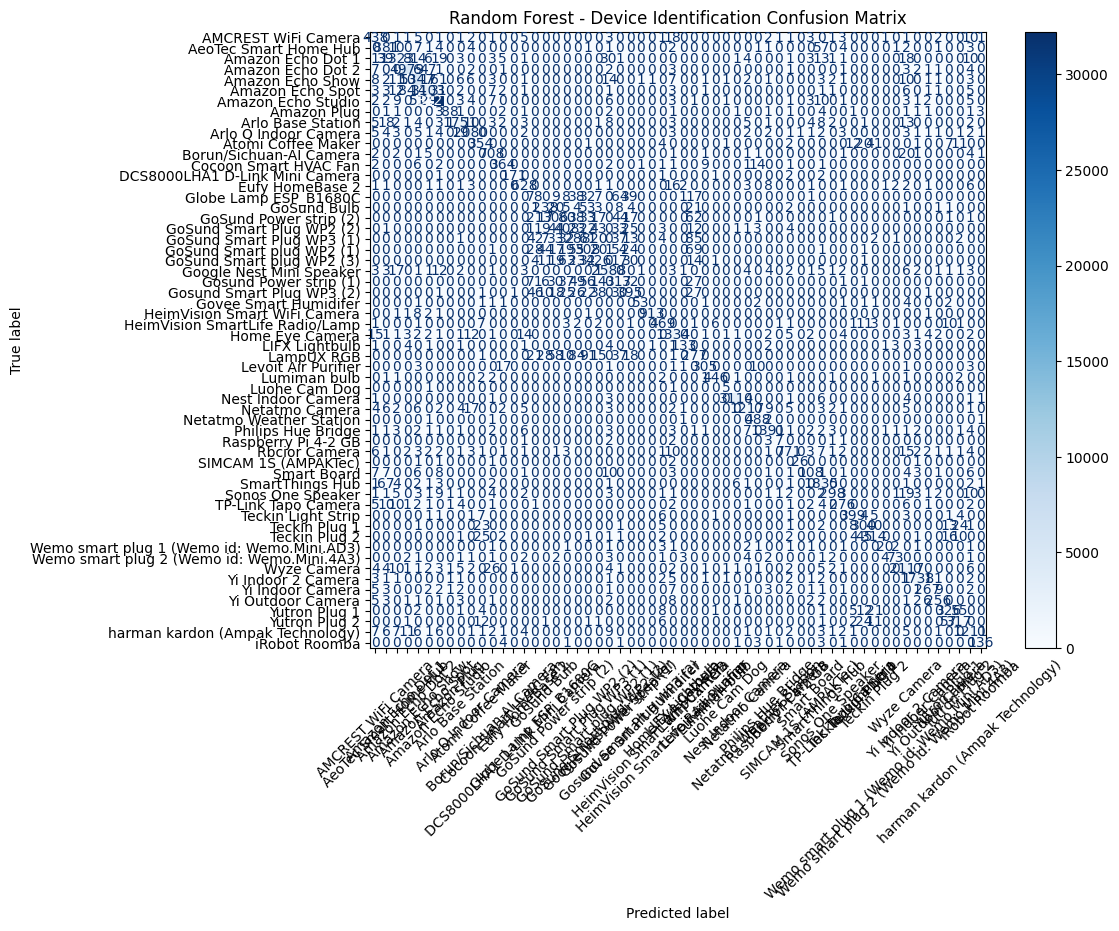

In [ ]:
# -------------------------------
# Confusion Matrix for Device Identification
# -------------------------------

# If you used LabelEncoder, use integer labels for the display_labels
cm_device = confusion_matrix(y_test_device, rf_y_pred_device)
disp_device = ConfusionMatrixDisplay(confusion_matrix=cm_device, display_labels=le_device.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp_device.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Random Forest - Device Identification Confusion Matrix")
plt.xticks(rotation=45)
plt.show()


In [ ]:
import pandas as pd

# If your y_test_device is encoded: use numeric keys
classes_device = [str(i) for i in range(len(le_device.classes_))]

# Extract metrics
precision_device = [report_device[cls]['precision'] for cls in classes_device]
recall_device = [report_device[cls]['recall'] for cls in classes_device]
f1_device = [report_device[cls]['f1-score'] for cls in classes_device]

# Create table as DataFrame
df_device_metrics = pd.DataFrame({
    'Device Class': le_device.classes_,
    'Precision': precision_device,
    'Recall': recall_device,
    'F1-Score': f1_device,
})

print("\nRandom Forest - Device Identification Metrics Table:")
print(df_device_metrics)



Random Forest - Device Identification Metrics Table:
                                  Device Class  Precision    Recall  F1-Score
0                          AMCREST WiFi Camera   0.805147  0.870775  0.836676
1                        AeoTec Smart Home Hub   0.825679  0.898063  0.860352
2                            Amazon Echo Dot 1   0.921309  0.879070  0.899694
3                            Amazon Echo Dot 2   0.974364  0.983798  0.979058
4                             Amazon Echo Show   0.969889  0.968484  0.969186
5                             Amazon Echo Spot   0.960681  0.945460  0.953010
6                           Amazon Echo Studio   0.994291  0.995550  0.994920
7                                  Amazon Plug   0.936170  0.765217  0.842105
8                            Arlo Base Station   0.963676  0.945975  0.954744
9                         Arlo Q Indoor Camera   0.968343  0.968343  0.968343
10                          Atomi Coffee Maker   0.806378  0.779736  0.792833
11        

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [ ]:
# Train AdaBoost for attack detection
ada_model_attack = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model_attack.fit(X_train_attack, y_train_attack)

# Train AdaBoost for device identification
ada_model_device = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model_device.fit(X_train_device, y_train_device)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [ ]:
# Evaluate AdaBoost for attack detection
ada_y_pred_attack = ada_model_attack.predict(X_test_attack)
print("AdaBoost - Attack Detection Performance:")
print(f"Accuracy: {accuracy_score(y_test_attack, ada_y_pred_attack):.2f}")
print(classification_report(y_test_attack, ada_y_pred_attack))

# Evaluate AdaBoost for device identification
ada_y_pred_device = ada_model_device.predict(X_test_device)
print("\\nAdaBoost - Device Identification Performance:")
print(f"Accuracy: {accuracy_score(y_test_device, ada_y_pred_device):.2f}")
print(classification_report(y_test_device, ada_y_pred_device, target_names=le_device.classes_))

AdaBoost - Attack Detection Performance:
Accuracy: 0.88
                  precision    recall  f1-score   support

   BenignTraffic       0.78      0.88      0.83     26147
    DNS_Spoofing       0.87      0.80      0.83     28606
MITM-ArpSpoofing       0.98      0.95      0.96     31758

        accuracy                           0.88     86511
       macro avg       0.88      0.87      0.87     86511
    weighted avg       0.88      0.88      0.88     86511

\nAdaBoost - Device Identification Performance:
Accuracy: 0.48
                                            precision    recall  f1-score   support

                       AMCREST WiFi Camera       0.00      0.00      0.00       503
                     AeoTec Smart Home Hub       0.00      0.00      0.00       981
                         Amazon Echo Dot 1       0.00      0.00      0.00      1505
                         Amazon Echo Dot 2       0.47      0.64      0.54      5061
                          Amazon Echo Show       0.

c:\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!pip install lightgbm

DEPRECATION: Loading egg at c:\python\python311\lib\site-packages\ember-0.1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [ ]:
# Train LightGBM for attack detection
lgb_model_attack = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1,n_jobs=2)
lgb_model_attack.fit(X_train_attack, y_train_attack)

# Train LightGBM for device identification
lgb_model_device = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1,n_jobs=2)
lgb_model_device.fit(X_train_device, y_train_device)

LGBMClassifier(n_jobs=2, random_state=42, verbose=-1)

In [ ]:
# Evaluate LightGBM for attack detection
lgb_y_pred_attack = lgb_model_attack.predict(X_test_attack)
print("LightGBM - Attack Detection Performance:")
print(f"Accuracy: {accuracy_score(y_test_attack, lgb_y_pred_attack):.2f}")
print(classification_report(y_test_attack, lgb_y_pred_attack))

# Evaluate LightGBM for device identification
lgb_y_pred_device = lgb_model_device.predict(X_test_device)
print("\\nLightGBM - Device Identification Performance:")
print(f"Accuracy: {accuracy_score(y_test_device, lgb_y_pred_device):.2f}")
print(classification_report(y_test_device, lgb_y_pred_device, target_names=le_device.classes_))

LightGBM - Attack Detection Performance:
Accuracy: 0.98
                  precision    recall  f1-score   support

   BenignTraffic       0.96      0.98      0.97     26147
    DNS_Spoofing       0.98      0.96      0.97     28606
MITM-ArpSpoofing       1.00      0.98      0.99     31758

        accuracy                           0.98     86511
       macro avg       0.98      0.98      0.98     86511
    weighted avg       0.98      0.98      0.98     86511

\nLightGBM - Device Identification Performance:
Accuracy: 0.39
                                            precision    recall  f1-score   support

                       AMCREST WiFi Camera       0.00      0.00      0.00       503
                     AeoTec Smart Home Hub       0.04      0.01      0.01       981
                         Amazon Echo Dot 1       0.58      0.12      0.20      1505
                         Amazon Echo Dot 2       0.89      0.10      0.18      5061
                          Amazon Echo Show       0.

/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [ ]:
# Train Random Forest for attack detection
rf_model_attack = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=2, class_weight='balanced')
rf_model_attack.fit(X_train_attack, y_train_attack)

# Train LightGBM for attack detection
lgb_model_attack = LGBMClassifier(n_jobs=2,n_estimators=100, random_state=42, verbose=-1)
lgb_model_attack.fit(X_train_attack, y_train_attack)

# Train Random Forest for device identification
rf_model_device = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=2, class_weight='balanced')
rf_model_device.fit(X_train_device, y_train_device)

# Train LightGBM for device identification
lgb_model_device = LGBMClassifier(n_jobs=2,n_estimators=100, random_state=42, verbose=-1)
lgb_model_device.fit(X_train_device, y_train_device)

LGBMClassifier(n_jobs=2, random_state=42, verbose=-1)

In [ ]:
# Define hybrid model for attack detection
hybrid_model_attack = VotingClassifier(
    estimators=[('rf', rf_model_attack), ('lgb', lgb_model_attack)],
    voting='soft'  # 'soft' uses predicted probabilities, 'hard' uses majority voting
)

from sklearn.utils import parallel_backend

with parallel_backend('threading', n_jobs=2):
    hybrid_model_attack.fit(X_train_attack, y_train_attack)



# Evaluate hybrid model for attack detection
hybrid_y_pred_attack = hybrid_model_attack.predict(X_test_attack)
print("Hybrid Model - Attack Detection Performance:")
print(f"Accuracy: {accuracy_score(y_test_attack, hybrid_y_pred_attack):.2f}")
print(classification_report(y_test_attack, hybrid_y_pred_attack))






# Define hybrid model for device identification
hybrid_model_device = VotingClassifier(
    estimators=[('rf', rf_model_device), ('lgb', lgb_model_device)],
    voting='soft'
)
with parallel_backend('threading', n_jobs=2):
    hybrid_model_device.fit(X_train_device, y_train_device)




# Evaluate hybrid model for device identification
hybrid_y_pred_device = hybrid_model_device.predict(X_test_device)
print("\\nHybrid Model - Device Identification Performance:")
print(f"Accuracy: {accuracy_score(y_test_device, hybrid_y_pred_device):.2f}")
print(classification_report(y_test_device, hybrid_y_pred_device, target_names=le_device.classes_))

/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/utils/deprecation.py:66: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


Hybrid Model - Attack Detection Performance:
Accuracy: 0.99
                  precision    recall  f1-score   support

   BenignTraffic       0.98      0.99      0.98     26147
    DNS_Spoofing       0.99      0.98      0.98     28606
MITM-ArpSpoofing       1.00      0.99      0.99     31758

        accuracy                           0.99     86511
       macro avg       0.99      0.99      0.99     86511
    weighted avg       0.99      0.99      0.99     86511



/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/utils/deprecation.py:66: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


\nHybrid Model - Device Identification Performance:
Accuracy: 0.49
                                            precision    recall  f1-score   support

                       AMCREST WiFi Camera       0.96      0.10      0.18       503
                     AeoTec Smart Home Hub       0.44      0.09      0.15       981
                         Amazon Echo Dot 1       0.75      0.26      0.39      1505
                         Amazon Echo Dot 2       0.98      0.55      0.70      5061
                          Amazon Echo Show       0.54      0.58      0.56      5521
                          Amazon Echo Spot       0.41      0.24      0.30      3282
                        Amazon Echo Studio       1.00      0.93      0.96     32363
                               Amazon Plug       1.00      0.15      0.26       115
                         Arlo Base Station       0.95      0.46      0.62      1851
                      Arlo Q Indoor Camera       0.05      0.95      0.10      2148
        

/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [ ]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Train KNN models
knn_model_attack = KNeighborsClassifier(n_neighbors=5, n_jobs=2)
knn_model_attack.fit(X_train_attack, y_train_attack)

knn_model_device = KNeighborsClassifier(n_neighbors=5, n_jobs=2)
knn_model_device.fit(X_train_device, y_train_device)

# Cell for KNN evaluation
# Evaluate KNN for attack detection
knn_y_pred_attack = knn_model_attack.predict(X_test_attack)
print("KNN - Attack Detection Performance:")
print(f"Accuracy: {accuracy_score(y_test_attack, knn_y_pred_attack):.2f}")
print(classification_report(y_test_attack, knn_y_pred_attack))

# Evaluate KNN for device identification
knn_y_pred_device = knn_model_device.predict(X_test_device)
print("\\nKNN - Device Identification Performance:")
print(f"Accuracy: {accuracy_score(y_test_device, knn_y_pred_device):.2f}")
print(classification_report(y_test_device, knn_y_pred_device, target_names=le_device.classes_))


KNN - Attack Detection Performance:
Accuracy: 0.99
                  precision    recall  f1-score   support

   BenignTraffic       0.98      0.99      0.99     26147
    DNS_Spoofing       0.99      0.98      0.98     28606
MITM-ArpSpoofing       0.99      0.99      0.99     31758

        accuracy                           0.99     86511
       macro avg       0.99      0.99      0.99     86511
    weighted avg       0.99      0.99      0.99     86511

\nKNN - Device Identification Performance:
Accuracy: 0.90
                                            precision    recall  f1-score   support

                       AMCREST WiFi Camera       0.64      0.81      0.71       503
                     AeoTec Smart Home Hub       0.67      0.81      0.73       981
                         Amazon Echo Dot 1       0.82      0.82      0.82      1505
                         Amazon Echo Dot 2       0.96      0.97      0.97      5061
                          Amazon Echo Show       0.96      0.

In [ ]:
# Cell for CatBoost training
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Train CatBoost models
cat_model_attack = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
cat_model_attack.fit(X_train_attack, y_train_attack)

cat_model_device = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
cat_model_device.fit(X_train_device, y_train_device)

# Cell for CatBoost evaluation
# Evaluate CatBoost for attack detection
cat_y_pred_attack = cat_model_attack.predict(X_test_attack)
print("CatBoost - Attack Detection Performance:")
print(f"Accuracy: {accuracy_score(y_test_attack, cat_y_pred_attack):.2f}")
print(classification_report(y_test_attack, cat_y_pred_attack))

# Evaluate CatBoost for device identification
cat_y_pred_device = cat_model_device.predict(X_test_device)
print("\\nCatBoost - Device Identification Performance:")
print(f"Accuracy: {accuracy_score(y_test_device, cat_y_pred_device):.2f}")
print(classification_report(y_test_device, cat_y_pred_device, target_names=le_device.classes_))



CatBoost - Attack Detection Performance:
Accuracy: 0.97
                  precision    recall  f1-score   support

   BenignTraffic       0.96      0.98      0.97     26147
    DNS_Spoofing       0.97      0.96      0.97     28606
MITM-ArpSpoofing       0.99      0.98      0.99     31758

        accuracy                           0.97     86511
       macro avg       0.97      0.97      0.97     86511
    weighted avg       0.97      0.97      0.97     86511

\nCatBoost - Device Identification Performance:
Accuracy: 0.74
                                            precision    recall  f1-score   support

                       AMCREST WiFi Camera       0.39      0.42      0.40       503
                     AeoTec Smart Home Hub       0.43      0.48      0.45       981
                         Amazon Echo Dot 1       0.49      0.47      0.48      1505
                         Amazon Echo Dot 2       0.80      0.83      0.81      5061
                          Amazon Echo Show       0.

/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


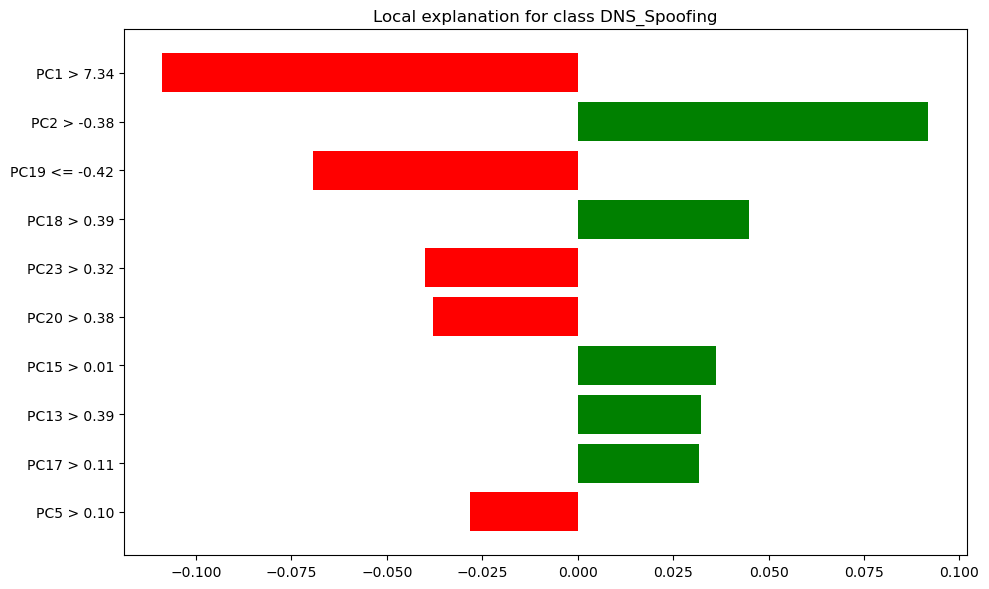

In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt


feature_names = [f'PC{i+1}' for i in range(X_reduced.shape[1])]
model_to_explain = rf_model_attack

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_reduced),
    mode='classification',
    feature_names=feature_names,
    categorical_features=[],
    verbose=False,
    class_names=model_to_explain.classes_,
    discretize_continuous=True 
)


instance_idx = 5
instance = X_reduced[instance_idx].reshape(1, -1)

exp = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=lambda x: model_to_explain.predict_proba(x),
    num_features=10,
    num_samples=1000  
)


fig = exp.as_pyplot_figure(label=1)  
fig.set_size_inches(10, 6)         

plt.tight_layout()
plt.savefig("lime_explanation.png", dpi=300)
plt.show()
